# Capstone Week 7
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor and firm dictionary mapper](#Make-advisor-and-firm-dictionary-mapper)
- [EDA](#EDA)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
    - [Regression](#Regression)
        - [Calculate Baseline](#Calculate-Baseline)
        - [`sklearn` Feature Selection](#sklearn-Feature-Selection)
        - [Make function to output deciles](#Make-function-to-output-deciles)
    - [Classification](#Classification)
        - [Calculate Baseline-Classification](#Calculate-Baseline-Classification)
        - [Classification Feature Selection](#Classification-Feature-Selection)
- [Fairness and Bias](#Fairness-and-Bias)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("../Transaction Data.xlsx", sheet_name='Transactions18')
df19 = pd.read_excel("../Transaction Data.xlsx", sheet_name='Transactions19')
firm = pd.read_excel("../Firm Information.xlsx", sheet_name="Rep summary")

## Merge 2018 and 2019

In [3]:
df = pd.merge(
    df18,
    df19,
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
df.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31


## Make advisor and firm dictionary mapper

In [4]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [5]:
adviser_lookup[10]

'85102150753418532658'

In [6]:
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(firm['Contact ID'])}

In [7]:
firm_lookup[10]

'0001806'

[Back to Top](#Index)
# EDA

In [8]:
# !conda install -yc conda-forge pandas-profiling

In [9]:
# from pandas_profiling import ProfileReport

# missing_diagrams = {
#     'heatmap': True, 'dendrogram': True, 'matrix':True, 'bar': True,
# }

# profile = ProfileReport(df, title='Nuveen Profile Report', missing_diagrams=missing_diagrams)

# profile.to_file(output_file="nuveen_profiling.html")

[Back to Top](#Index)
# Data Cleaning

In [10]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID',
    'Contact ID', 'CustomerID', 'Firm ID', 'Office ID',
    'Channel','Sub channel', 'Firm name'
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 
]

FIRM_COLS = ['Contact ID', 'Channel','Sub channel',]

# Make `Firm` data pipeline

In [11]:
df = pd.merge(df, firm, left_on="CONTACT_ID", right_on='Contact ID')
df.head(1)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31,0047433,240,1688552,85101152293608716061,National Broker-Dealer,NACS,"UBS Financial Services, Inc."


In [12]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [13]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [14]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(df):
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.apply(lambda x: max(0, x))
    else:
        return df.select_dtypes(include='number').clip(lower=0)

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler

In [16]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [17]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans),
    ('PowerTransformer', PowerTransformer(standardize=False))
])

y_train_reg = pd.Series(
    targ_pipe_reg.fit_transform(y_train_reg.to_frame()).squeeze(),
    index=y_train_reg.index
)
y_test_reg = pd.Series(
    targ_pipe_reg.transform(y_test_reg.to_frame()).squeeze(),
    index=y_test_reg.index
)

Transform the classification target

In [18]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)

y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)

Create the pipeline for the features

In [19]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [20]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [21]:
X_test_prepared

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
2052,-0.199371,-0.093252,-0.207843,-0.089515,-0.573977,-0.221485,-0.430359,0.301512,-0.784078,0.083188,-0.536570,0.782602,-0.373415,0.063655,-0.258339,-0.085083,-0.151783,-0.609095,0.095688,-0.415778,-0.518275,-0.078960,-0.058282,-0.012892,-0.022410,6.269968,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.259043,-0.056194,-0.01714,-0.070413
2758,-0.159635,-0.048462,-0.207843,-0.205862,-0.153081,0.591014,-0.430359,-0.442232,0.201190,1.035094,-0.536570,-0.561332,-0.693256,-0.888855,-0.102691,-0.083568,-0.151026,0.091395,0.146089,-0.415778,-0.039400,-0.078960,-0.065878,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.073601,-0.056194,-0.01714,-0.070413
4334,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.093857,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.027182,-0.079302,-0.040421,-0.012892,-0.018591,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.063076,-0.056194,-0.01714,-0.070413
9047,0.118515,0.050076,-0.207843,-0.205862,0.688712,0.591014,-0.430359,-0.442232,1.186457,1.035094,-0.536570,-0.561332,-0.053573,0.063655,-0.096939,-0.073236,-0.133039,0.091103,0.144632,-0.415778,-0.014956,-0.085461,-0.058935,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.066749,-0.056194,-0.01714,-0.070413
7001,0.009242,0.171009,-0.115750,0.259524,-0.153081,1.403513,0.318971,1.789002,0.201190,1.035094,0.858232,2.126536,0.266268,0.063655,-0.098609,-0.085083,-0.077280,0.070873,-0.189406,-0.415778,-0.037940,-0.079761,-0.037229,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.068738,-0.056194,-0.01714,-0.070413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,0.376797,0.112782,1.357732,0.375870,1.109608,0.591014,1.817630,1.789002,2.171725,1.987000,3.647837,3.470469,0.905951,1.016164,0.240511,-0.085083,0.168188,-0.352809,-0.123876,1.289958,-0.098124,-0.029076,-0.138181,-0.012892,4.647680,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,0.335295,-0.056194,-0.01714,-0.070413
785,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.693256,-0.888855,-0.097262,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.078960,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.067133,-0.056194,-0.01714,-0.070413
7614,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.085369,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.065118,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.052964,-0.056194,-0.01714,-0.070413
9577,-0.000692,-0.084294,-0.115750,-0.205862,0.688712,-0.221485,0.318971,-0.442232,1.186457,0.083188,0.858232,-0.561332,0.266268,1.016164,-0.065484,-0.079434,-0.123801,0.091395,0.155591,-0.415778,0.018326,-0.065245,-0.058282,-0.012892,-0.023818,-0.038570,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.040609,-0.037756,-

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

[Back to Top](#Index)
## Regression

Predict the sales of an advisor

In [22]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE

### Calculate Baseline

In [23]:
y_baseline = y_test_reg.mean() * np.ones(y_test_reg.shape, dtype='float') # use mean as prediction
print(np.sqrt(mean_squared_error(y_test_reg, y_baseline)))

4.27808136019108


In [24]:
y_baseline

array([4.09257969, 4.09257969, 4.09257969, ..., 4.09257969, 4.09257969,
       4.09257969])

### `sklearn` Feature Selection

In [25]:
rf = RandomForestRegressor()
rfe = RFE(rf)
rfe.fit(X_train_prepared, y_train_reg)

RFE(estimator=RandomForestRegressor())

This is a boolean mask indicating which columns were selected from the `RFE` fitting

In [26]:
rfe.support_

array([ True,  True,  True, False,  True,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False])

In [27]:
X_train_prepared.columns[rfe.support_]

Index(['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'No_of_fund_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MULTIPLE', 'aum_P_MF',
       'aum_P_SMA'],
      dtype='object')

Select columns from RFE

In [28]:
X_train_reg_rfe = X_train_prepared.loc[:, rfe.support_]
X_test_reg_rfe = X_test_prepared.loc[:, rfe.support_]

In [29]:
rf2 = RandomForestRegressor()
rf2.fit(X_train_reg_rfe, y_train_reg)

RandomForestRegressor()

In [30]:
y_test_preds = rf2.predict(X_test_reg_rfe)

In [31]:
print(np.sqrt(mean_squared_error(y_test_reg, y_test_preds)))

2.9003796310394865


Create a function to evaulate regression models

In [32]:
def evaluate_regression(model, X, y, training=False,):
    if training:
        print("Training Cross Validation Scores:")
        print(-cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
        print('-'*55)
        preds = model.predict(X)
        lim = max(preds.max(), y.max())
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.scatter(x=y, y=preds, alpha=0.4)
        ax.plot([0, lim], [0, lim])
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_title("Actual vs Predicted - Regression")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted");
    else:
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_preds))
        print("Testing Data Performance:")
        print('-'*55)
        print(f"RMSE:\t{rmse}")
        preds = model.predict(X)
        lim = max(preds.max(), y.max())
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.scatter(x=y, y=preds, alpha=0.4)
        ax.plot([0, lim], [0, lim])
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_title("Actual vs Predicted - Regression")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted");

Training Cross Validation Scores:
[3.04777058 2.99413259 3.0091948  2.98107082 2.73709506]
-------------------------------------------------------


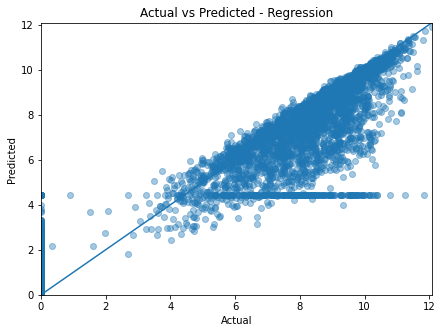

In [33]:
evaluate_regression(rf2, X_train_reg_rfe, y_train_reg, training=True)

Testing Data Performance:
-------------------------------------------------------
RMSE:	2.9003796310394865


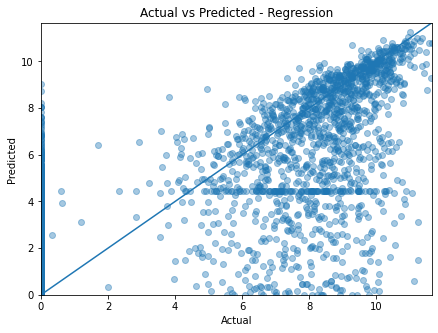

In [34]:
evaluate_regression(rf2, X_test_reg_rfe, y_test_reg)

[Back to Top](#Index)
### Make function to output deciles

In [35]:
y_test_preds = pd.Series(rf2.predict(X_test_reg_rfe), index=y_test_reg.index)

In [36]:
y_test_preds = (
    targ_pipe_reg
        .named_steps['PowerTransformer']
        .inverse_transform(y_test_preds.to_frame())
        .squeeze())
y_test_preds

array([2.54057806e+01, 3.69744200e+03, 5.11432515e+00, ...,
       5.35514199e+01, 2.16477151e+04, 1.12565502e+05])

In [37]:
def output_deciles(model, X, y, transform=False):
    if transform:
        results = pd.DataFrame(model.predict(X), index=X.index, columns=['predictions'])
        results['actual'] = y.values
        results['deciles'] = pd.qcut(results['predictions'], 10,labels=False)
        results['predictions'] = (targ_pipe_reg
            .named_steps['PowerTransformer']
            .inverse_transform(results['predictions'].to_frame())
            .squeeze())
        results['actual'] = (targ_pipe_reg
            .named_steps['PowerTransformer']
            .inverse_transform(results['actual'].to_frame())
            .squeeze())
        results['contact_id'] = results.index.map(adviser_lookup)
        return results
    else:
        results = pd.DataFrame(model.predict(X), index=X.index, columns=['predictions'])
        results['actual'] = y.values
        results['deciles'] = pd.qcut(results['predictions'], 10, labels=False)
        results['contact_id'] = results.index.map(adviser_lookup)
        return results

In [38]:
regression_deciles = output_deciles(rf2, X_test_reg_rfe, y_test_reg, transform=True)

In [39]:
regression_deciles

,predictions,actual,deciles,contact_id
2052,25.405781,0.00,4,85101112703496609682
2758,3697.441998,5055.19,7,4478951
4334,5.114325,0.00,3,85102121286175700667
9047,13413.981994,100777.23,7,85101131446010585430
7001,402.352977,22500.00,6,85202162573702072494
...,...,...,...,...
3541,136590.406336,495457.51,8,4420073
785,144.376556,0.00,5,10751191354315089820
7614,53.551420,0.00,4,0301701
9577,21647.715112,1908.85,8,85202133384955811399


In [40]:
reg_chart = (regression_deciles
    .groupby('deciles')
    .agg({'actual': ['mean', 'count']})
    .droplevel(0, axis=1)
    .reset_index()
)

In [41]:
reg_chart['deciles'] = reg_chart['deciles'].apply(lambda x: (x-10)*-1)

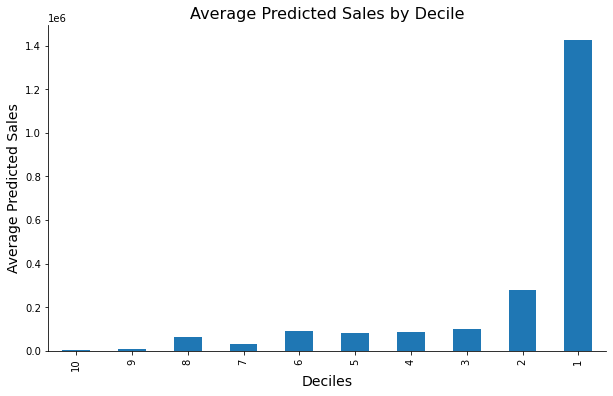

In [42]:
fig, axes = plt.subplots(figsize=(10,6))
reg_chart.plot(kind='bar', x='deciles', y='mean', ax=axes, legend=None)
axes.set_xlabel("Deciles", fontsize=14)
axes.set_ylabel("Average Predicted Sales", fontsize=14)
axes.set_title("Average Predicted Sales by Decile", fontsize=16)
axes.spines['top'].set_visible(False);
axes.spines['right'].set_visible(False);

In [43]:
regression_deciles.sort_values(by='deciles')

,predictions,actual,deciles,contact_id
7558,0.000000e+00,0.000000e+00,0,4468469
7400,0.000000e+00,0.000000e+00,0,4493743
5940,0.000000e+00,0.000000e+00,0,4306896
1370,0.000000e+00,0.000000e+00,0,85202142205901896573
8736,0.000000e+00,0.000000e+00,0,0315549
...,...,...,...,...
7716,3.110169e+05,2.176292e+05,9,1420926
4403,2.163255e+05,3.149614e+05,9,4316668
4420,1.559224e+05,1.085495e+06,9,10751172303434633848
4986,1.625581e+06,9.572984e+05,9,4320517


[Back to Top](#Index)
## Classification

Predict if an advisor will make at least one sale

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

### Calculate Baseline-Classification

In [45]:
from sklearn.dummy import DummyClassifier

In [46]:
dummy_cl = DummyClassifier(strategy='most_frequent') # use majority

In [47]:
dummy_cl.fit(X_train_prepared, y_train_cl)
y_baseline = dummy_cl.predict(X_test)
print(classification_report(y_test_cl, y_baseline, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      2236
         1.0       0.00      0.00      0.00       766

    accuracy                           0.74      3002
   macro avg       0.37      0.50      0.43      3002
weighted avg       0.55      0.74      0.64      3002



### Classification Feature Selection

In [48]:
from sklearn.feature_selection import SelectFromModel

In [49]:
gbc = GradientBoostingClassifier()

# find subset of features
sfm = SelectFromModel(gbc, threshold='median')
sfm.fit(X_train_prepared, y_train_cl)
X_train_cl_sfm = pd.DataFrame(
    sfm.transform(X_train_prepared),
    index=X_train_prepared.index,
    columns=X_train_prepared.columns[sfm.get_support()])
X_test_cl_sfm = pd.DataFrame(
    sfm.transform(X_test_prepared),
    index=X_test_prepared.index,
    columns=X_test_prepared.columns[sfm.get_support()])

# fit model with selected features
gbc.fit(X_train_cl_sfm, y_train_cl)

GradientBoostingClassifier()

Create predictions

In [50]:
y_test_preds = gbc.predict(X_test_cl_sfm)

In [51]:
print(classification_report(y_test_cl, y_test_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      2236
         1.0       0.55      0.26      0.35       766

    accuracy                           0.76      3002
   macro avg       0.67      0.59      0.60      3002
weighted avg       0.72      0.76      0.72      3002



Create function to evaluate model

In [52]:
def evaluate_classifier(cl_model, X, y, training=False):
    if training:
        print("Training Cross Validation Scores:")
        print(-cross_validate(cl_model, X, y, scoring='f1')['test_score'])
        print('-'*55)
        preds = cl_model.predict(X)
        print(classification_report(y, preds))
    else:
        print("Testing Data Performance:")
        print('-'*55)
        preds = cl_model.predict(X)
        print(classification_report(y, preds))

In [53]:
evaluate_classifier(gbc, X_train_cl_sfm, y_train_cl, training=True)

Training Cross Validation Scores:
[-0.15347722 -0.17874396 -0.3618677  -0.3515625  -0.35502959]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88      5248
         1.0       0.72      0.32      0.44      1755

    accuracy                           0.80      7003
   macro avg       0.76      0.64      0.66      7003
weighted avg       0.79      0.80      0.77      7003



In [54]:
evaluate_classifier(gbc, X_test_cl_sfm, y_test_cl)

Testing Data Performance:
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      2236
         1.0       0.55      0.26      0.35       766

    accuracy                           0.76      3002
   macro avg       0.67      0.59      0.60      3002
weighted avg       0.72      0.76      0.72      3002



In [55]:
gbc.predict_proba(X_test_cl_sfm)[:, 1]

array([0.19891948, 0.26435827, 0.1118309 , ..., 0.1106749 , 0.36389482,
       0.219157  ])

In [56]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:, 1], index=X.index, columns=['predictions'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['predictions'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results

In [57]:
class_results = output_deciles_class(gbc, X_test_cl_sfm, y_test_cl)

In [58]:
class_results

,predictions,actual,deciles,contact_id
2052,0.198919,0.0,4,85101112703496609682
2758,0.264358,1.0,6,4478951
4334,0.111831,0.0,2,85102121286175700667
9047,0.289096,1.0,6,85101131446010585430
7001,0.250771,0.0,6,85202162573702072494
...,...,...,...,...
3541,0.529455,1.0,9,4420073
785,0.505723,0.0,8,10751191354315089820
7614,0.110675,0.0,2,0301701
9577,0.363895,0.0,7,85202133384955811399


In [59]:
class_res1 = (class_results
                  .groupby('deciles')
                  .agg({'actual': 'sum', 'contact_id': 'count'})
                  .rename(columns={'contact_id': 'count'})
                  .reset_index()
             )
class_res1['deciles'] = class_res1['deciles'].apply(lambda x: (x - 10)*-1)
class_res1 = class_res1.sort_values(by='deciles')
class_res1.to_csv('class_lift.csv', index=False)

In [60]:
cl_preds = pd.Series(gbc.predict(X_train_cl_sfm), index=X_train_cl_sfm.index)
cl_preds.value_counts()

0.0    6228
1.0     775
dtype: int64

In [61]:
# !pip install scikit-plot

In [62]:
import scikitplot as skplt

In [63]:
y_test_cl_preds = gbc.predict_proba(X_test_cl_sfm)

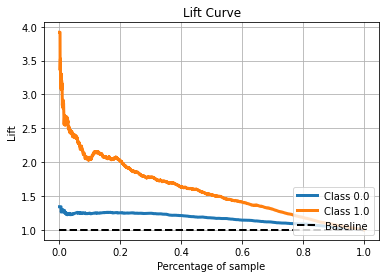

In [64]:
skplt.metrics.plot_lift_curve(y_test_cl, y_test_cl_preds);

[Back to Top](#Index)
## Fairness and Bias
1. [Visit the Aequitas project website](http://www.datasciencepublicpolicy.org/projects/aequitas/)
2. [Aequitas Fairness GitHub](https://github.com/dssg/aequitas)
3. [Aequitas API Docs](https://dssg.github.io/aequitas/api/aequitas.html)
4. [Aequitas Example](https://dssg.github.io/aequitas/examples/compas_demo.html)

In [65]:
# !pip install aequitas

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings; warnings.simplefilter('ignore')

In [67]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]

### Load sample data

In [68]:
RAW_DATA = 'https://raw.githubusercontent.com/dssg/aequitas/master/examples/data/compas_for_aequitas.csv'
df = pd.read_csv(RAW_DATA)

In [69]:
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


### About the data
Risk assessment by race

COMPAS produces a risk score that predicts a person’s likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of “low” risk according to COMPAS, while a 1 indicates “high” or “medium” risk.

In [70]:
aq_palette = sns.diverging_palette(225, 35, n=2)

Look at the prediction distributons along the race, sex, and age attributes.

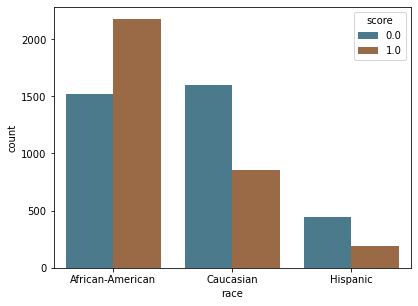

In [71]:
by_race = sns.countplot(
            x="race", hue="score", 
            data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])],
            palette=aq_palette
)

Race by label

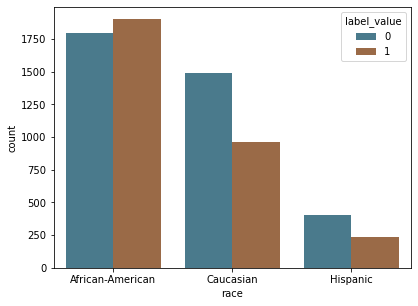

In [72]:
label_by_race = sns.countplot(
    x="race", hue="label_value", 
    data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], 
    palette=aq_palette
)

Predictions by Sex

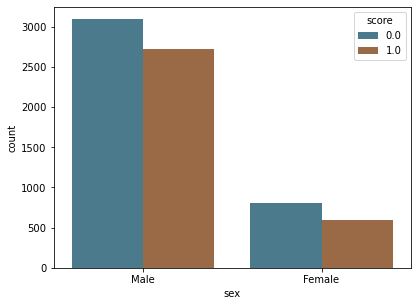

In [73]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

Labels by Sex

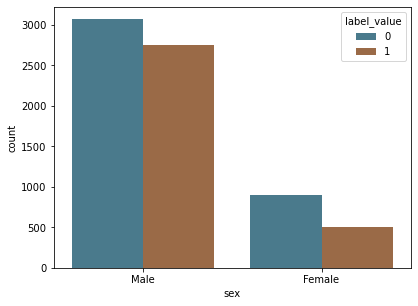

In [74]:
label_by_age = sns.countplot(
    x="sex", hue="label_value", 
    data=df, palette=aq_palette
)

Predictions by Age

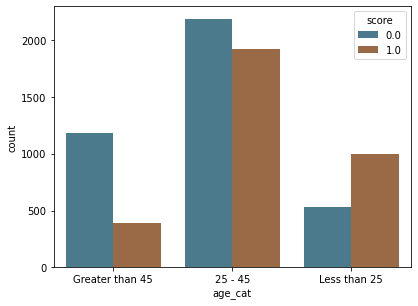

In [75]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

Labels by Age

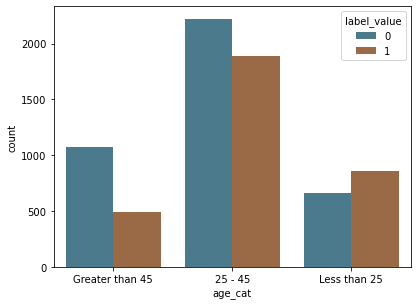

In [76]:
label_by_sex = sns.countplot(
    x="age_cat", hue="label_value", 
    data=df, palette=aq_palette
)

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates.

#### Initialize a `Group()` instance to see metrics in cross tabulations

In [77]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 0 {'rank_abs': [3317]}


In [78]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785
6,0,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105
8,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723
9,0,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.250000,181,285,897,213,498,1078,1576,7214,0.315990


#### Plot the false negative rates

These show how often the model misses someone that does commit another crime within that group.

In [79]:
aqp = Plot()

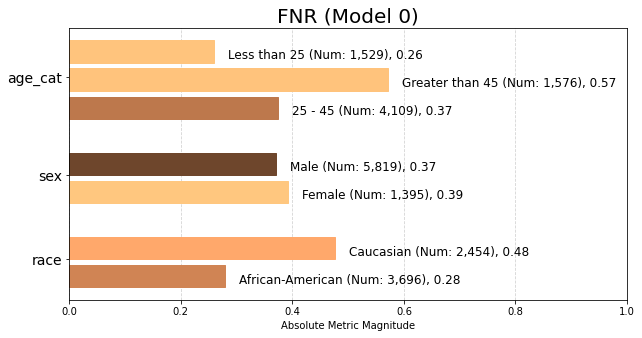

In [80]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

In [ ]:
a = aqp.plot_group_metric_all(xtab, ncols=3)